In [1]:
# Imports

import os
import sys

sys.path.append("..")

from os import listdir
from os.path import isfile, join
import app.dvmg.patterns
import numpy as np
import json
import random
import inspect

In [2]:
# Get patterns list
patterns_list: list = inspect.getmembers(
        app.dvmg.patterns, inspect.isclass)
f_patterns_list: list = [
    ptrn for ptrn in patterns_list if ptrn[0] != 'PatternBase' and ptrn[0] != 'Custom']

print(f_patterns_list)

[('LinearDecrease', <class 'app.dvmg.patterns.builtin.LinearDecrease'>), ('LinearIncrease', <class 'app.dvmg.patterns.builtin.LinearIncrease'>), ('Normal', <class 'app.dvmg.patterns.builtin.Normal'>), ('NormalFlipped', <class 'app.dvmg.patterns.builtin.NormalFlipped'>), ('Plain', <class 'app.dvmg.patterns.builtin.Plain'>), ('Sigmoid', <class 'app.dvmg.patterns.builtin.Sigmoid'>), ('SigmoidReversed', <class 'app.dvmg.patterns.builtin.SigmoidReversed'>)]


In [3]:
# Create DataSet

onlyfiles = [f for f in listdir("../dataset/") if isfile(join("../dataset/", f))]

# Create empty dataset lists
dataset_model_1: list[tuple[tuple, str]] = list() # ((X,y), pattern_name)
test_dataset_model_1: list[tuple[tuple, str]] = list() # ((test_data_X,test_data_y), pattern_name)

dataset_model_2: list[tuple[np.ndarray, int]] = list() # (X, class_id)
test_dataset_model_2: list[tuple[np.ndarray, int]] = list() # (X, class_id)

# Paths to data files
training_file_path = f'../dataset/{onlyfiles[0]}'
test_file_path = f'../dataset/{onlyfiles[1]}'

def parse(path: str, pattern_name: str) -> tuple[np.ndarray, np.ndarray, list]:

    X_model_2: list[tuple[np.ndarray, int]] = list() # Данные для обучения для полносвязной НС
    X_model_1 = np.empty((0, 16), int) # Данные для обучения (координаты реконструкции фазового портрета) до сортировки для перцептронов
    y_model_1 = np.array([]) # 1 - соответствует правильному паттерну, на который тренируется сеть, 0 - всем остальным до сортировки для перцептронов

    random_value = np.array([]) # Случайная величина для перемешивания датасета
    with open(path, 'r') as json_file:
        data: dict = json.load(json_file)
        
        for ptrn in list(data.keys()):
            all_coordinates: list = data[ptrn]
            
            for local_cordinates in all_coordinates:
                X_model_2.append((np.array([np.append(np.array(local_cordinates['x']), np.array(local_cordinates['y'])).tolist()]), list(data.keys()).index(ptrn)))
                X_model_1 = np.append(X_model_1, np.array([np.append(np.array(local_cordinates['x']), np.array(local_cordinates['y'])).tolist()]), axis=0)
                y_model_1 = np.append(y_model_1, 1) if ptrn == pattern_name else np.append(y_model_1, 0)
                random_value = np.append(random_value, np.random.rand()) # Генерация случайного числа от 0 до 1

    # Сортировка по случайным величинам
    return {
        "X_model_1": np.array([x for _, x, _ in sorted(zip(random_value, X_model_1, y_model_1), key=lambda x: x[0])]),
        "y_model_1": np.array([y for _, _, y in sorted(zip(random_value, X_model_1, y_model_1), key=lambda x: x[0])]),
        "X_model_2": [x for _, x in sorted(zip(random_value, X_model_2), key=lambda x: x[0])]
    }


for ptrn in f_patterns_list:

    pattern_name, signature = ptrn
    data = parse(training_file_path, pattern_name)

    X_model_1 = data["X_model_1"]
    y_model_1 = data["y_model_1"]
    X_model_2 = data["X_model_2"]

    dataset_model_1 += [((X_model_1, y_model_1), pattern_name)]
    dataset_model_2 = [*dataset_model_2, *X_model_2]

    test_data = parse(test_file_path, pattern_name)

    X_model_1 = test_data["X_model_1"]
    y_model_1 = test_data["y_model_1"]
    X_model_2 = test_data["X_model_2"]

    test_dataset_model_1 += [((X_model_1, y_model_1), pattern_name)]
    test_dataset_model_2 = [*test_dataset_model_2, *X_model_2]

print(dataset_model_1[0])
print('\n-----------------\n')
print(dataset_model_2[0])
print('\n-----------------\n')

print(test_dataset_model_1[0])
print('\n-----------------\n')
print(test_dataset_model_2[0])
print('\n-----------------\n')

print(len(dataset_model_1))



((array([[21, 15,  2, ...,  0, 23, 20],
       [28, 28, 13, ...,  0, 16, 13],
       [20, 30, 14, ...,  0, 16, 13],
       ...,
       [27, 40, 15, ...,  0, 10,  6],
       [30, 16, 10, ...,  0, 12, 22],
       [24, 23,  3, ...,  0, 19, 15]]), array([0., 0., 0., ..., 1., 0., 0.])), 'LinearDecrease')

-----------------

(array([[ 21,  15,   2,   0, -26, -46, -23,   0,  21,   0,  -2, -11, -26,
          0,  23,  20]]), 1)

-----------------

((array([[23, 20,  6, ...,  0, 18, 11],
       [19, 42, 13, ...,  0, 15, 13],
       [25, 36, 24, ...,  0, 11,  9],
       ...,
       [15, 14,  4, ...,  0, 23, 24],
       [23, 17,  6, ...,  0, 14, 19],
       [28, 35, 14, ...,  0, 11, 11]]), array([0., 0., 0., ..., 0., 0., 1.])), 'LinearDecrease')

-----------------

(array([[ 23,  20,   6,   0, -18, -54, -18,   0,  23,   0,  -6, -14, -18,
          0,  18,  11]]), 5)

-----------------

7


[Epoch]: 0
[Epoch]: 1
[Epoch]: 2
[Epoch]: 3
[Epoch]: 4
[Epoch]: 5
[Epoch]: 6
[Epoch]: 7
[Epoch]: 8
[Epoch]: 9
[Epoch]: 10
[Epoch]: 11
[Epoch]: 12
[Epoch]: 13
[Epoch]: 14
[Epoch]: 15
[Epoch]: 16
[Epoch]: 17
[Epoch]: 18
[Epoch]: 19
[Epoch]: 20
[Epoch]: 21
[Epoch]: 22
[Epoch]: 23
[Epoch]: 24
[Epoch]: 25
[Epoch]: 26
[Epoch]: 27
[Epoch]: 28
[Epoch]: 29
[Epoch]: 30
[Epoch]: 31
[Epoch]: 32
[Epoch]: 33
[Epoch]: 34
[Epoch]: 35
[Epoch]: 36
[Epoch]: 37
[Epoch]: 38
[Epoch]: 39
[Epoch]: 40
[Epoch]: 41
[Epoch]: 42
[Epoch]: 43
[Epoch]: 44
[Epoch]: 45
[Epoch]: 46
[Epoch]: 47
[Epoch]: 48
[Epoch]: 49
[Epoch]: 50
[Epoch]: 51
[Epoch]: 52
[Epoch]: 53
[Epoch]: 54
[Epoch]: 55
[Epoch]: 56
[Epoch]: 57
[Epoch]: 58
[Epoch]: 59
[Epoch]: 60
[Epoch]: 61
[Epoch]: 62
[Epoch]: 63
[Epoch]: 64
[Epoch]: 65
[Epoch]: 66
[Epoch]: 67
[Epoch]: 68
[Epoch]: 69
[Epoch]: 70
[Epoch]: 71
[Epoch]: 72
[Epoch]: 73
[Epoch]: 74
[Epoch]: 75
[Epoch]: 76
[Epoch]: 77
[Epoch]: 78
[Epoch]: 79
[Epoch]: 80
[Epoch]: 81
[Epoch]: 82
[Epoch]: 83
[E

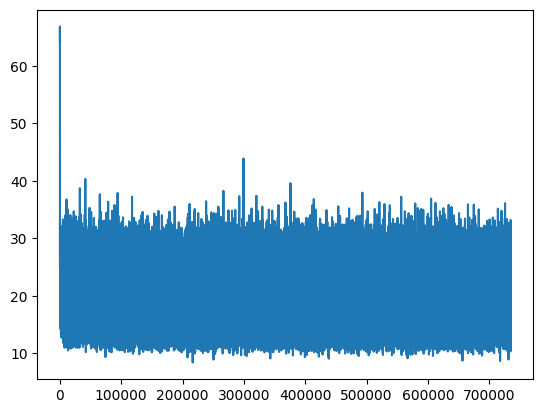

In [4]:
import random
import numpy as np

INPUT_DIM = 16
OUT_DIM = 7
H_DIM = 20

_dataset = dataset_model_2

def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

ALPHA = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 20

loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(_dataset)
    print(f'[Epoch]: {ep}')
    for i in range(len(_dataset) // BATCH_SIZE):

        batch_x, batch_y = zip(*_dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        # Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Backward
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Update
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)

def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy():
    correct = 0
    for x, y in _dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(_dataset)
    return acc

accuracy = calc_accuracy()
print("Accuracy:", accuracy)

import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()



In [5]:
_test_dataset = test_dataset_model_2
random.shuffle(_test_dataset)

counter = 0
for data in _test_dataset:
    x, y = data
    z = predict(x[0])
    y_pred = np.argmax(z)
    if y_pred == y:
        counter += 1
print("Test accuracy: " + str(counter/len(_test_dataset)))

Test accuracy: 0.5491428571428572


In [6]:
# Perceptron

class Perceptron:
    def __init__(self, lr=0.01, epochs=5):
        self.lr = lr
        self.epochs = epochs
        self.weights = None

    def fit(self, X, y):
        """
        Our fit function trains on the dataset X and tries to predict vector y,
        Using the learning rate, it will modify it's weight vector to increase
        it's accuracy in predictions.
        It will iterate over the X dataset as defined by the epochs.
        Args:
            X: The input data (numpy array of shape [n_samples * m_features])
            y: Class labels vector (numpy array of shape [n_samples])
        """
        # a vector of floats between 0 and 1
        weights = np.random.rand(X.shape[1],)

        for epoch in range(self.epochs):
            # list of predicted classes for our accuracy calculation
            predicted = []
            for i_index, sample in enumerate(X):
                y_hat = self.predict(sample, weights)
                predicted.append(y_hat)  # add our new prediction to the array
                for j_index, feature in enumerate(weights):
                    # update our weight values
                    delta = self.lr * (y[i_index] - y_hat)
                    delta = delta * sample[j_index-1]
                    weights[j_index-1] = weights[j_index-1] + delta
            # print('[Epoch {ep}] Accuracy: {acc}'.format(
            #     ep=epoch, acc=self._calculate_accuracy(y, predicted)
            # ))
        self.weights = weights

    def _calculate_accuracy(self, actual, predicted):
        """
        Calculate the accuracy of predictions for this epoch.
        Args:
            actual: vector of actual class values (the y vector) [n_samples]
            predicted: vector of predicted class values [n_samples]
        """
        return sum(np.array(predicted) == np.array(actual)) / float(len(actual))

    def predict(self, x, w):
        """
        Create a binary prediction from an activation function on the data
        sample and the weight vector.
        Args:
            x: vector of the data sample - shape [m_features]
            w: vector of the weights - shape [m_features]
        Returns:
            0 or 1
        """
        res = self._sum(x, w)
        # print(res)
        return 1 if res > 0.0 else 0.0

    def _sum(self, x, w):
        """
        Multiply our sample and weight vector elements then the sum of the
        result.
        Args:
            x: vector of the data sample - shape [m_features]
            w: vector of the weights - shape [m_features]
        Returns:
            Int of the sum of vector products
        """
        return np.sum(np.dot(x, np.transpose(w)))


In [7]:
# Create perceptron instances and train

perceptrons: list[Perceptron] = [Perceptron() for _ in range(len(f_patterns_list))]
perceptrons_patterns_names: list = list()

k = 0
for data in dataset_model_1:
    (X, y), name = data
    perceptrons[k].fit(X, y)
    perceptrons_patterns_names += [name]
    k += 1

[print(perceptrons[p].weights, perceptrons_patterns_names[p]) for p in range(len(perceptrons))]

[ 0.23558847  0.70967551  0.69967165  0.15226211 -0.00267816  2.04889067
  1.97388103  0.2870995   0.8774714   0.47042999 -0.12429756 -0.75257473
 -0.07974182  0.61544487 -0.31043208 -1.57843199] LinearDecrease
[-0.5209635  -2.13628357 -1.19934838  0.17773131 -0.35558855 -0.80917086
 -0.23953604  0.57778902 -0.09152127  0.88990412  2.2838268   1.39516509
  0.04298971  0.09403932  1.02789566  1.62106374] LinearIncrease
[-0.13037277 -1.06425909  0.72598258  0.12750871  0.12328131  0.19310597
  0.54843282  0.95963232  0.11110715  0.95868581  0.11793149 -0.00906508
 -0.37070491  0.66707705  0.21666684 -0.66939259] Normal
[-0.48643902 -0.16419079 -0.07735508  0.91838677  0.32240228 -0.96866866
  0.73418079  0.83184932 -0.42169328  0.78295665  0.39752096  0.66971994
 -0.27444877  0.22045789 -0.52104711 -0.5271287 ] NormalFlipped
[ 0.84415201 -1.54822822 -1.09082851  0.48815982 -1.3591966   1.82824726
  2.09946159  0.63676144  0.79103338  0.62926229  2.14799783 -0.89798902
 -1.77899859  0.227

[None, None, None, None, None, None, None]

In [8]:
# Test linked perceptrons with softmax

test_data_ = test_dataset_model_2

print(perceptrons_patterns_names)

new_dataset_model_2: list[tuple[np.ndarray, int]] = list() # (X, class_id)
print(len(test_data_))
for t_p_t in test_data_:
    t_t, tr = t_p_t
    true_answer = perceptrons_patterns_names[tr]
    perceptrons_predictions: list = []
    for perc in perceptrons:
        perceptrons_predictions += [perc._sum(t_t[0], perc.weights)]
    new_dataset_model_2.append((np.array([perceptrons_predictions]), perceptrons_patterns_names.index(true_answer)))

len(new_dataset_model_2)
new_dataset_model_2



['LinearDecrease', 'LinearIncrease', 'Normal', 'NormalFlipped', 'Plain', 'Sigmoid', 'SigmoidReversed']
147000


[(array([[-110.84315115,    5.47699991,  -32.24402444,  -23.20851358,
           -45.68517185,   -4.445926  , -126.48096244]]),
  5),
 (array([[   8.66177555, -149.31684755,  -44.22747967,  -51.4260408 ,
           -64.07902696, -130.66376486,  -37.99791315]]),
  6),
 (array([[  31.64849802, -174.34358877,  -47.15568522,  -51.85687324,
           -55.50549583, -142.84283501,  -26.69945145]]),
  0),
 (array([[-45.82364086, -62.55753656, -35.44545131, -32.94874423,
          -15.19561527, -45.91869234, -92.29097609]]),
  5),
 (array([[-31.823876  , -76.18937253, -41.34669097, -36.57866994,
          -17.4781035 , -65.09891334, -75.80972742]]),
  4),
 (array([[  -3.08858563, -121.33926253,  -39.43190258,  -38.41439505,
           -38.18734043,  -92.06307676,  -59.55466222]]),
  0),
 (array([[-22.10597158, -63.88679356, -35.44865508, -56.03260625,
           22.66461946, -63.5876105 , -60.55003992]]),
  4),
 (array([[-49.04438756, -40.71698734, -41.99581823, -37.39163271,
           15.479

[Epoch]: 0
[Epoch]: 1
[Epoch]: 2
[Epoch]: 3
[Epoch]: 4
[Epoch]: 5
[Epoch]: 6
[Epoch]: 7
[Epoch]: 8
[Epoch]: 9
[Epoch]: 10
[Epoch]: 11
[Epoch]: 12
[Epoch]: 13
[Epoch]: 14
[Epoch]: 15
[Epoch]: 16
[Epoch]: 17
[Epoch]: 18
[Epoch]: 19
[Epoch]: 20
[Epoch]: 21
[Epoch]: 22
[Epoch]: 23
[Epoch]: 24
[Epoch]: 25
[Epoch]: 26
[Epoch]: 27
[Epoch]: 28
[Epoch]: 29
[Epoch]: 30
[Epoch]: 31
[Epoch]: 32
[Epoch]: 33
[Epoch]: 34
[Epoch]: 35
[Epoch]: 36
[Epoch]: 37
[Epoch]: 38
[Epoch]: 39
[Epoch]: 40
[Epoch]: 41
[Epoch]: 42
[Epoch]: 43
[Epoch]: 44
[Epoch]: 45
[Epoch]: 46
[Epoch]: 47
[Epoch]: 48
[Epoch]: 49
[Epoch]: 50
[Epoch]: 51
[Epoch]: 52
[Epoch]: 53
[Epoch]: 54
[Epoch]: 55
[Epoch]: 56
[Epoch]: 57
[Epoch]: 58
[Epoch]: 59
[Epoch]: 60
[Epoch]: 61
[Epoch]: 62
[Epoch]: 63
[Epoch]: 64
[Epoch]: 65
[Epoch]: 66
[Epoch]: 67
[Epoch]: 68
[Epoch]: 69
[Epoch]: 70
[Epoch]: 71
[Epoch]: 72
[Epoch]: 73
[Epoch]: 74
[Epoch]: 75
[Epoch]: 76
[Epoch]: 77
[Epoch]: 78
[Epoch]: 79
[Epoch]: 80
[Epoch]: 81
[Epoch]: 82
[Epoch]: 83
[E

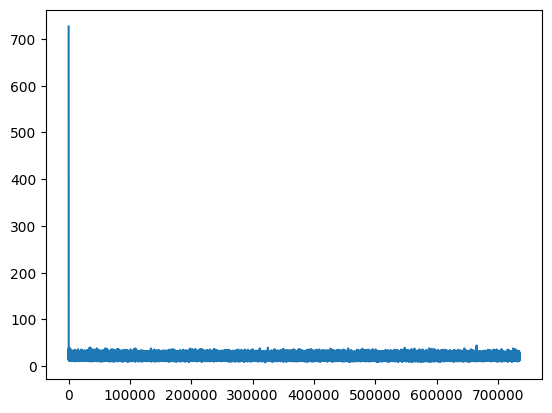

In [9]:
# Нейронная сеть соединяющая выводы перцептронов
import random
import numpy as np

INPUT_DIM = 7
OUT_DIM = 7
H_DIM = 12

_dataset = new_dataset_model_2

def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

ALPHA = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 20

loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(_dataset)
    print(f'[Epoch]: {ep}')
    for i in range(len(_dataset) // BATCH_SIZE):

        batch_x, batch_y = zip(*_dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        # Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Backward
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Update
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)

def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy():
    correct = 0
    for x, y in _dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(_dataset)
    return acc

accuracy = calc_accuracy()
print("Accuracy:", accuracy)

import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()
 